前陣子選舉的時候蠻常看ptt政黑板的，看久了其實可以發現光是看標題就可以發現大家的討論話題好像都會圍繞在某些特定主題上  
尤其是在政黑板，好像更容易反映時下大家對某個政治議題的風向和看法。  
也是因為這樣我想說可以來做一個簡單的text clustering，或許能在cluster之間發現一些模式。

這次是對政黑板在3/14發表的其中45則文章的標題進行分群的工作：  
那我們就開始吧

# 1. 進行爬蟲

在進行標題的分群之前首先當然要去ptt把文章標題的資料都爬下來


In [99]:
import requests
from bs4 import BeautifulSoup

url = "https://www.ptt.cc/bbs/HatePolitics/index.html" #政黑板
cookies = {'over18': '1'} #確認有超過18歲
titles=[]

for i in range(2): #往上爬2頁
    r = requests.get(url, cookies = cookies)
    soup = BeautifulSoup(r.text,"html.parser")
    sel = soup.select("div.title a") #標題
    u = soup.select("div.btn-group.btn-group-paging a") #a標籤
    url = "https://www.ptt.cc"+ u[1]["href"] #上一頁的網址
    

    for s in sel: #印出純標題
        if "Re:" in s.text:
            titles.append(str(s.text[9:]))
        else:
            titles.append(str(s.text[5:]))

for title in titles:
    print(title)


在政黑板這邊一共爬到了45則文章的標題
將所爬到的所有標題印出後，可以先把他們存到一個txt檔中供下一步斷詞及建立word2vec模型使用

# 2. 開始進行 text clustering

取得了文章的標題之後，就可以利用以下步驟達成標題的分群工作：
* 進行斷詞
* 利用word2vec訓練模型
* 將標題轉換成向量形式
* 使用k-means群集分析法
* 畫圖及解釋

## 2.1 進行斷詞

我使用的是jieba進行每則標題的斷詞工作，比較特別的是因為政黑板包含比較多特殊的專有名詞，像是「柯粉」或是各種人名，以及各種政黨名稱。  
若直接進行斷詞，會造成本來應該是一個token的詞被以錯誤的方式切割，如：「民」，「眾黨」就不是我們想要的結果。

因此，在這裡需要加入自己的詞頻表"userdic.txt"並在裡面加入這些特殊的詞，斷詞出來的結果才會更準確，模型的訓練上也會精準許多。

In [1]:
from gensim.models import Word2Vec
import nltk
from nltk.cluster import KMeansClusterer
import jieba
import numpy as np
  
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE

titles=[]
training_set=[]
stopWords = []
jieba.load_userdict('userdic.txt') #建立詞頻表

with open('stopWords.txt', 'r', encoding='UTF-8') as file:   #建立停用詞列表
    for data in file.readlines():
        data = data.strip()
        stopWords.append(data)

with open('ptt_titles.txt', 'r', encoding='UTF-8') as file:  #叫出剛剛存下來的標題文字檔
    for data in file.readlines():
        data = data.strip()
        titles.append(data)
        
for title in titles:
    seg_list = jieba.lcut(title, cut_all=False)
    remainderWords = list(filter(lambda a: a not in stopWords and a != '\n', seg_list))   #去除停用詞
    training_set.append(remainderWords)
    
print(training_set)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/p4/c_vh6zxn1bd854ygcxd6w8w40000gn/T/jieba.cache
Loading model cost 1.567 seconds.
Prefix dict has been built successfully.


[['司法院', '行政院', '是不是', '蔡英文', '講話', '放屁'], ['台灣', '禁醫護', '人員', '出國', '是不是', '先知'], ['吳介聲', '／', '美', '眾議院', '台北', '法案', '台灣'], ['滅', '不了', '柯', '可毀', '掉', '幕僚'], ['吉', 'FB', '-', '社會', '議題', '大論鬥', ' ', '(', '來賓', ':', '黃國昌', ' ', '苗博雅', ')'], ['綠畜', '邏輯', '生', '台灣', ' ', '台灣'], ['該禁', '歐洲', '旅遊團'], ['北部', '高中'], ['柯粉', '經弱', '議員', '滅團'], ['柯文哲', '陳時中', '不同'], ['吉', 'FB', '-', '社會', '議題', '大論鬥', ' ', '(', '來賓', ':', '黃國昌', ' ', '苗博雅', ')'], ['詢問', '一下', ' ', '版主', '投票', '問題'], ['王浩宇', '484', '火力', '全開', '拚', '上位'], ['政治', '黑特板', '板規', '20191119', 'V5.6'], ['賭文', '開獎', '專區', ' ', '請', '版友', '遵守', '承諾'], ['請', '提供', '推薦', '文章'], ['板主選舉', ' ', '候選人', '名單'], ['啟臣', '未', '提', '九二', '共識', ' ', '台師', '教授', '邯鄲', '學步'], ['陳揮文', ' ', '意', '唐鳳', '驢', ',', '了不起'], ['滅', '不了', '柯', '可毀', '掉', '幕僚'], ['柯', 'P', '是不是', '健忘症'], ['啟臣', '未', '提', '九二', '共識', ' ', '台師', '教授', '邯鄲', '學步'], ['爭議', '走', '沒人', '追'], ['川普', '是不是', '欠', '歐巴馬', '健保', '一個', '道歉'], ['民眾黨', '日後晚', '會', '擔任', '混音', 'DJ'], ['柯粉', '

以上就是利用jieba將每則標題斷詞出來的結果，雖然已經加入詞頻表，但人名還是容易出差錯，像是「啟臣」。


## 2.2 利用word2vec訓練模型


有了vocabulary之後，就可以利用word2vec建立自己的詞嵌入模型了！  
這邊其實只是想訓練自己使用word2vec建立模型的能力，畢竟我只採用45則標題，vocabulary的數量應該蠻少的，應該是不足以訓練出有解釋力的模型，但姑且當做一個小嘗試～～

In [ ]:
model = Word2Vec(training_set, min_count=1)

## 2.3 將標題轉換成向量

而取得訓練好的模型後，接下來就是將每則標題轉換成向量的形式表達，這個步驟可以有三種不同做法：


### - 平均標題中所包含的所有詞向量
這是最直觀的做法; 既然要以向量代表一個句子，那就將句子中包含的所有詞彙的詞向量平均起來作為整個句子的向量。  
本篇即是使用這個做法
### - 將詞向量以TF-IDF加權後取平均
這個方法是上面提到方法的變形，TF-IDF會賦予一份文件中較重要的詞語較高的權重。  
因此如果先將所有詞向量乘上各自的TF-IDF權重，就可以將真正有代表性的詞彙凸顯出來，並壓制一些常用詞彙在模型中的影響。
### - 使用 doc2vec
doc2vec與word2vec由同一位作者發表，而doc2vec相較於word2vec有將句子中詞語的順序列入考量。  
所以在產生句向量時，doc2vec或許能更準確的capture不同句子間的關係。

這篇文章只使用了一種做法，自己也覺得很可惜，所以下次有時間一定會把title clustering(II) 產出，把第二種和第三種做法都試做看看，再做個簡單的結果比較。

In [2]:
def sent_vectorizer(sent, model):  #建立sentence vector
    sent_vec =[]
    numw = 0
    for w in sent:
        try:
            if numw == 0:
                sent_vec = model[w]
            else:
                sent_vec = np.add(sent_vec, model[w])
            numw+=1
        except:
            pass
     
    return np.asarray(sent_vec) / numw
  
  
X=[]
for record in training_set:
    X.append(sent_vectorizer(record, model))   
 
print ("========================")
print(X) #印出每個標題的vector


[array([-1.24322809e-03,  8.01940914e-05, -1.91818958e-03, -2.91404314e-03,
        1.71463087e-03,  1.62131374e-03, -3.47813737e-04, -1.30454439e-03,
        2.18028785e-03, -4.65505669e-04,  4.63856850e-07,  9.40772181e-04,
        1.80217437e-03, -7.23957375e-04, -2.16326863e-03,  1.30520016e-03,
        7.91137165e-04,  1.06557237e-03, -2.34822906e-03, -1.36267918e-04,
       -2.00288161e-03,  7.09351385e-04,  7.80229690e-04,  2.19220784e-03,
       -2.05326383e-03, -4.30112326e-04, -1.81946997e-03,  8.09603196e-04,
       -8.42052978e-05, -7.95314088e-04,  1.54867547e-03,  1.27234065e-03,
        1.06788951e-03,  9.31000512e-04,  7.18115829e-04, -4.51142929e-04,
        8.43069283e-04,  2.43897419e-04,  8.48794880e-04, -5.81701403e-04,
       -5.07106248e-04,  5.20937087e-04,  9.81858582e-04, -4.15782590e-04,
        4.17873234e-04, -1.74056925e-03,  1.36198418e-03,  2.52211583e-04,
        5.42300986e-04, -7.52703752e-04,  9.44144558e-04, -1.02016551e-03,
        4.90462931e-04, 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


## 2.4 使用k-mean群集分析法

成功產出每個標題所代表的vector後，我利用nltk裡的KmeansClusterer對這些標題進行群集分析(cluster analysis)，這邊終於快接近我的最終目標了！  

我只使用2個cluster下去跑，其實我也用過3個或甚至4個，但跑出來的結果好像都蠻雜亂的，看不出什麼模式，因此最後還是用2個當群集數量。  
其實更嚴謹來說，這邊應該要畫一個scree plot，然後在以圖形中的轉折處當作最佳的cluster數量，不過現在訓練資料也不是很足，還是先暫且使用兩個。

In [11]:
NUM_CLUSTERS=2
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
     
     
     
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_



## 2.5 畫圖及解釋
將cluster模型訓練好後，就可以利用matplotlib將圖畫出來，底下也順便將所有標題所屬的群集列出來，給大家參考，看看大家覺得不同cluster代表的主題是是什麼。

0 司法院與行政院是不是把蔡英文講話當放屁
0 台灣禁醫護人員出國是不是先知？
0 吳介聲／美眾議院通過《台北法案》，台灣
1 滅不了柯，但可毀掉他的幕僚
1 吉FB-社會議題大論鬥 (來賓:黃國昌 苗博雅)
1 綠畜邏輯：生在台灣 台灣就你的？
0 該禁歐洲旅遊團嗎？
1 北部那所高中啊？
0 柯粉已經弱到被議員滅團
1 柯文哲與陳時中的不同
1 吉FB-社會議題大論鬥 (來賓:黃國昌 苗博雅)
1 詢問一下大家 版主投票問題
0 王浩宇484火力全開要拚上位?
1 政治黑特板板規_20191119_V5.6
1 對賭文開獎專區 請版友遵守承諾
0 請大家提供推薦文章
1 板主選舉 候選人名單
1 啟臣未提九二共識 台師大教授：邯鄲學步
1 陳揮文 意：唐鳳你不就是驢,有啥了不起？
1 滅不了柯，但可毀掉他的幕僚
0 柯P是不是得了健忘症啊?
1 啟臣未提九二共識 台師大教授：邯鄲學步
1 為何這些爭議人走了後就沒人在追了
0 川普是不是欠歐巴馬健保一個道歉
0 民眾黨日後晚會誰來擔任混音DJ？
1 柯粉 電音趴的經費 不瞭解一下嗎？
0 台灣社會對特殊性向仍不友好
1 為什麼我 加入不了 台北好朋友QQ
0 武漢肺炎起源在那？
0 全部禁出國很難嗎？
1 王浩宇FB－林富男：習近平好棒棒！
0 全部禁出國很難嗎？
0 新南向已經徹底失敗了嗎？
1 DPP收佛地魔和TMD找黨員的不同
1 投票重新舉行
1 2020板主選舉
0 台灣敢ban掉所有的航線嗎？
0 民眾黨還有什麼獨特性？
0 所以林飛帆跟洪慈庸是哪裡酬庸？
0 中國趕緊復工了吧！
1 大家支持死刑嗎
0 中國趕緊復工了吧！
0 國外的總理、總統、州長、市長....
1 柯粉 電音趴的經費 不瞭解一下嗎？
0 台灣社會對特殊性向仍不友好


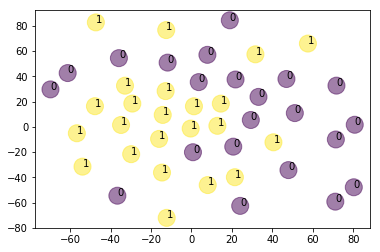

In [12]:
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
 
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model.fit_transform(X)
 
 
plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5)
 
 
for j in range(len(titles)):    
   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
   print ("%s %s" % (assigned_clusters[j],  titles[j]))
 
 
plt.show()

這裡分享我個人的解讀：

**0: 柯文哲相關  
  1: 國外（川普 歐巴馬 眾議院）or武漢肺炎**

雖然每次跑出來結果好像都不太一樣，圖也長得不太一樣，但通常一個cluster會代表柯文哲&民眾黨，另一個則是與肺炎或國外新聞比較相關。  
由圖來看，1號cluster聚集的比較密，比較團結; 0號cluster則好像散落在圖的各處，彼此連結性比較不高。  

這次能做出這樣的結果我自己是覺得蠻新奇的，畢竟原本是文字形式的標題透過轉換居然可以被聚類並畫在圖上，看出標題間彼此的關聯性，真的蠻有趣的。  
既然標題能做，我想之後應該也可以推廣到內文或留言，那邊的資料量更大，除了訓練出來的模型會更精確，也可以利用這些資訊看出社群媒體上的一些現象。    

不過近期的目標先還是以產出本篇的第二集為主，利用上面提到的TF-IDF和doc2vec再進行不同方法的分析。  
另外，這篇做的主要是使用非監督式學習的方法分群，但之後也會想寫一篇利用labeled data做文章分類的工作。


那大家就拭目以待吧～

## References
[1] https://ai.intelligentonlinetools.com/ml/text-clustering-word-embedding-machine-learning/  
[2] https://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/
